In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [3]:
# load dataset
use_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "TailNum",
    "CRSElapsedTime",
    "ArrDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "Diverted",
]

df = pd.read_csv("datasets/airline_arrival_delay/2007_light.csv", dtype={
    "Month": str,
    "DayofMonth": str,
    "DayOfWeek": str,
    "DepTime": str,
    "CRSDepTime": str,
    "CRSArrTime": str,
    "FlightNum": str,
    "Diverted": str
}, usecols=use_columns)

def add_prefix(columns, prefix, additional_text=""):
    new_columns = []
    
    for col in columns:
        transform = ''.join([e.capitalize() for e in col.split('_')])
        
        if prefix.lower() == col.lower():
            new_columns.append(f"{prefix}{additional_text}")
        else:
            new_columns.append(f"{prefix}{additional_text}{transform}")
            
    return new_columns

df_carriers = pd.read_csv("datasets/airline_arrival_delay/carriers.csv")
df_carriers.columns = add_prefix(df_carriers.columns, "Carrier")

df_planes = pd.read_csv("datasets/airline_arrival_delay/plane-data.csv")
df_planes.columns = add_prefix(df_planes.columns, "Plane")

df_airports_from = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_from.columns = add_prefix(df_airports_from.columns, "Airport", "From")

df_airports_to = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_to.columns = add_prefix(df_airports_to.columns, "Airport", "To")

In [4]:
df = pd.merge(df, df_carriers, left_on="UniqueCarrier", right_on="CarrierCode", how="inner")
df = pd.merge(df, df_planes, left_on="TailNum", right_on="PlaneTailnum", how="inner")
df = pd.merge(df, df_airports_from, left_on="Origin", right_on="AirportFromIata", how="inner")
df = pd.merge(df, df_airports_to, left_on="Dest", right_on="AirportToIata", how="inner")

In [5]:
del df_carriers, df_planes, df_airports_from, df_airports_to

In [6]:
# I only use 3.000.000 records due to computer capacity
df = df.sample(n=3000000)

## All columns and their description

2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. CRSDepTime: ~~ scheduled departure time (local, hhmm)
6. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
7. UniqueCarrier: ~~ unique carrier code
8. FlightNum: ~~ flight number
9. TailNum: ~~ plane tail number
10. CRSElapsedTime: ~~ in minutes ------ __have negative number__
11. ArrDelay: ~~ arrival delay, in minutes
12. Origin: ~~ origin IATA airport code
13. Dest: ~~ destination IATA airport code
14. Distance: ~~ in miles
15. TaxiIn: ~~ taxi in time, in minutes
16. TaxiOut: ~~ taxi out time in minutes
17. Cancelled: ~~ was the flight cancelled?
18. Diverted: ~~ 1 = yes, 0 = no

## Exploratory Data Analysis

In [7]:
# set labels for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# filter out cancelled flights
df = df[df["Cancelled"] == False]

# drop unnecessary columns after merging
df = df.drop([
    "UniqueCarrier",
    "CarrierCode",
    "TailNum",
    "PlaneTailnum",
    "Origin",
    "AirportFromIata",
    "Dest",
    "AirportToIata",
    "ArrDelay",
    "Cancelled",
    "AirportFromCountry",
    "AirportToCountry",
], axis=1)

In [9]:
# after filtering unnecessary columns, we now have only 30 features, 8 of them are numerical
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981616 entries, 3453826 to 5962517
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   DayofMonth          object 
 2   DayOfWeek           object 
 3   CRSDepTime          object 
 4   CRSArrTime          object 
 5   FlightNum           object 
 6   CRSElapsedTime      float64
 7   Distance            int64  
 8   TaxiIn              int64  
 9   TaxiOut             int64  
 10  Diverted            object 
 11  CarrierDescription  object 
 12  PlaneType           object 
 13  PlaneManufacturer   object 
 14  PlaneIssueDate      object 
 15  PlaneModel          object 
 16  PlaneStatus         object 
 17  PlaneAircraftType   object 
 18  PlaneEngineType     object 
 19  PlaneYear           object 
 20  AirportFrom         object 
 21  AirportFromCity     object 
 22  AirportFromState    object 
 23  AirportFromLat      float64
 24  AirportFromLong   

In [10]:
df.describe()

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong
count,2.981616e+06,2.981616e+06,2.981616e+06,2.981616e+06,2.981616e+06,2.981616e+06,2.981616e+06,2.981616e+06
mean,1.290130e+02,7.359395e+02,6.810592e+00,1.667062e+01,3.673789e+01,-9.555997e+01,3.673871e+01,-9.554722e+01
std,7.158336e+01,5.721997e+02,5.110238e+00,1.179769e+01,5.759306e+00,1.839655e+01,5.758658e+00,1.839505e+01
min,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.770189e+01,-1.766460e+02,1.770189e+01,-1.766460e+02
25%,7.800000e+01,3.250000e+02,4.000000e+00,1.000000e+01,3.343417e+01,-1.119778e+02,3.343417e+01,-1.119778e+02
50%,1.100000e+02,5.870000e+02,6.000000e+00,1.400000e+01,3.750517e+01,-8.997667e+01,3.750517e+01,-8.997667e+01
75%,1.600000e+02,9.650000e+02,8.000000e+00,1.900000e+01,4.077724e+01,-8.144247e+01,4.077724e+01,-8.131603e+01
max,6.600000e+02,4.962000e+03,5.450000e+02,4.030000e+02,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


#### Exploration

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ) (but in another dataset)

In [11]:
df.describe(include="O").T

,count,unique,top,freq
Month,2981616,12,8,266294
DayofMonth,2981616,31,12,100092
DayOfWeek,2981616,7,1,445465
CRSDepTime,2981616,1181,600,52755
CRSArrTime,2981616,1384,1930,10796
FlightNum,2981616,7561,1,2297
Diverted,2981616,2,0,2974652
CarrierDescription,2981616,19,Southwest Airlines Co.,467993
PlaneType,2827818,5,Corporation,2808386
PlaneManufacturer,2827818,35,BOEING,1167892


In [12]:
df.head(5).T

,3453826,5228334,5670575,3989037,6671867
Month,11,3,5,7,6
DayofMonth,8,29,30,28,19
DayOfWeek,4,4,3,6,2
CRSDepTime,615,815,635,650,1310
CRSArrTime,739,922,1001,1010,1500
FlightNum,5010,930,524,514,6100
CRSElapsedTime,84.0,67.0,146.0,140.0,50.0
Distance,264,270,867,929,122
TaxiIn,6,4,5,4,3
TaxiOut,24,17,21,21,13


In [13]:
print(f"Total rows: {len(df)}")

Total rows: 2981616


### Check missing values

In [14]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                      0
DayofMonth                 0
DayOfWeek                  0
CRSDepTime                 0
CRSArrTime                 0
FlightNum                  0
CRSElapsedTime             0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Diverted                   0
CarrierDescription         0
PlaneType             153798
PlaneManufacturer     153798
PlaneIssueDate        153798
PlaneModel            153798
PlaneStatus           153798
PlaneAircraftType     153798
PlaneEngineType       153798
PlaneYear             153798
AirportFrom                0
AirportFromCity         2116
AirportFromState        2116
AirportFromLat             0
AirportFromLong            0
AirportTo                  0
AirportToCity           2206
AirportToState          2206
AirportToLat               0
AirportToLong              0
IsLate                     0
dtype: int64

In [15]:
# the missing value only 5% which is not really significant => drop all missing value
df = df.dropna()

### Heatmap visualization

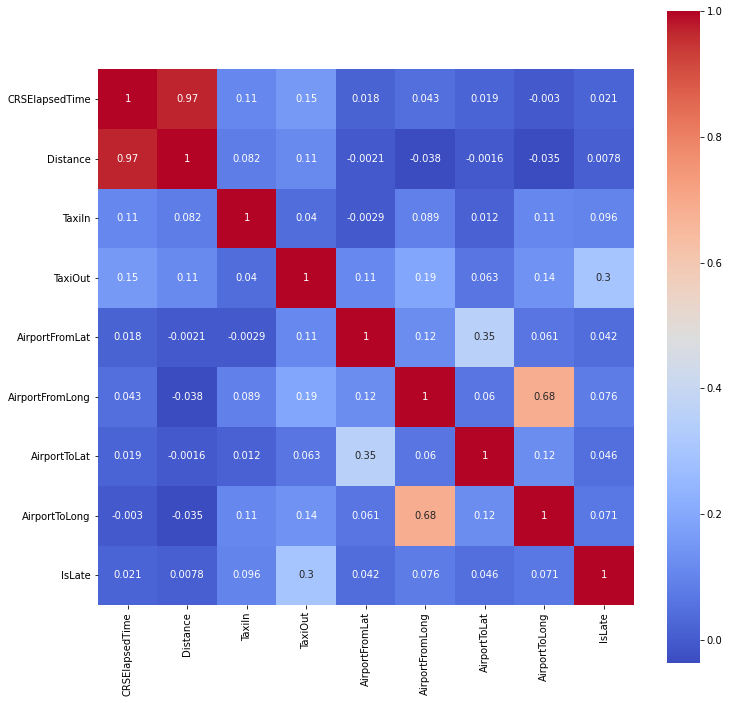

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

<Figure size 720x504 with 0 Axes>

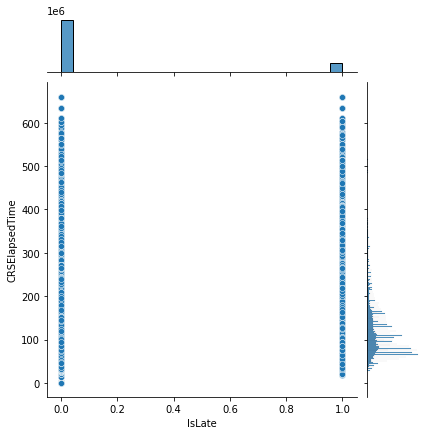

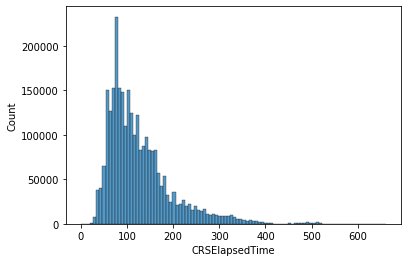

<Figure size 720x504 with 0 Axes>

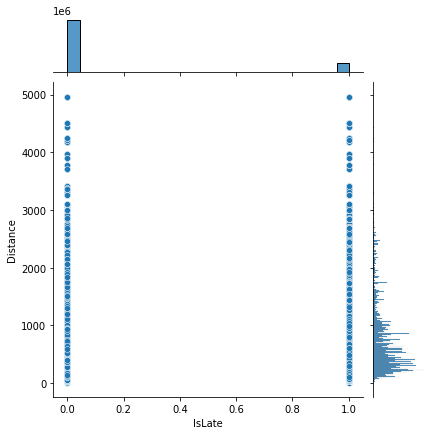

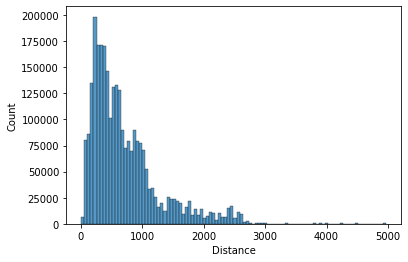

<Figure size 720x504 with 0 Axes>

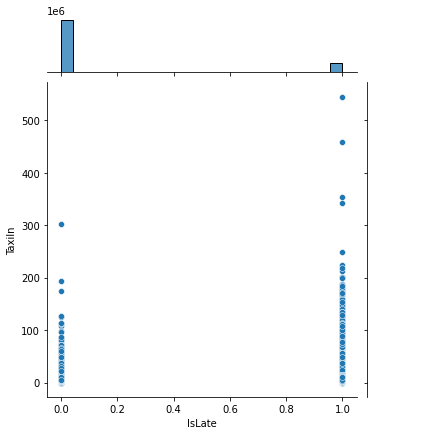

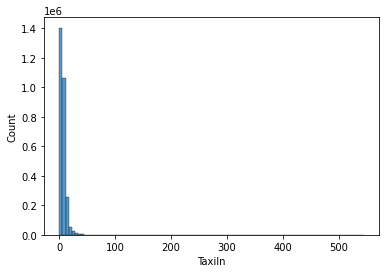

<Figure size 720x504 with 0 Axes>

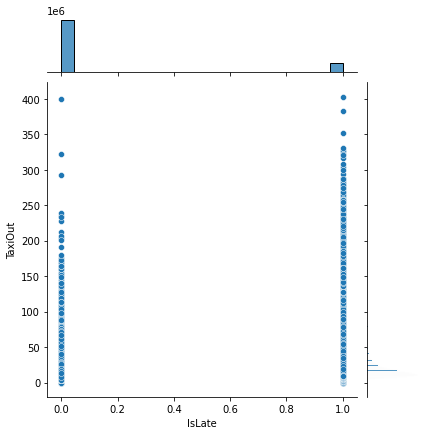

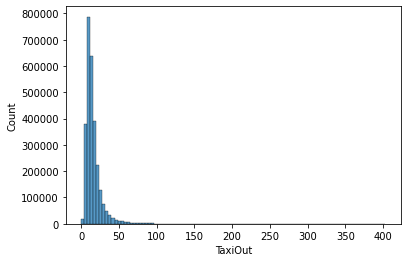

<Figure size 720x504 with 0 Axes>

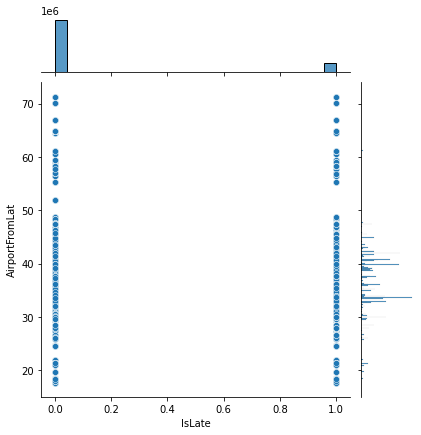

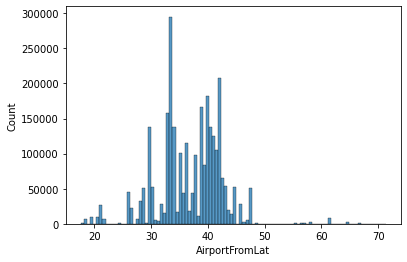

<Figure size 720x504 with 0 Axes>

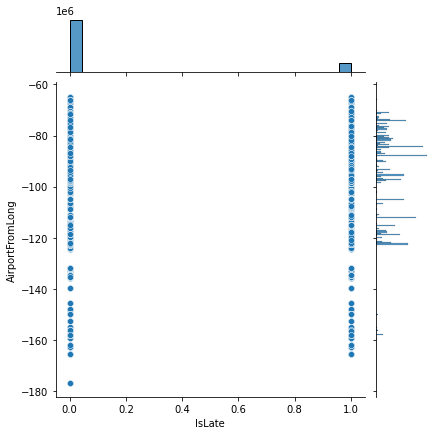

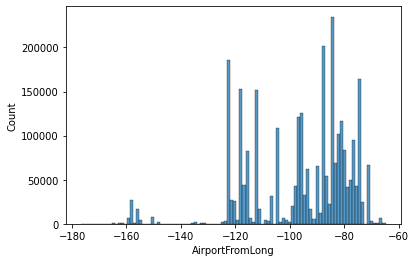

<Figure size 720x504 with 0 Axes>

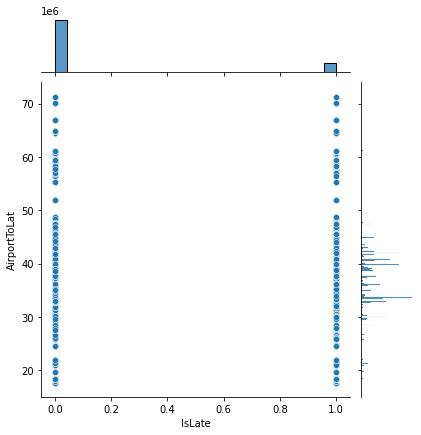

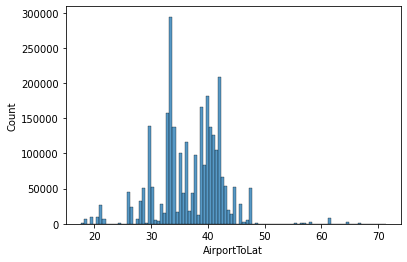

<Figure size 720x504 with 0 Axes>

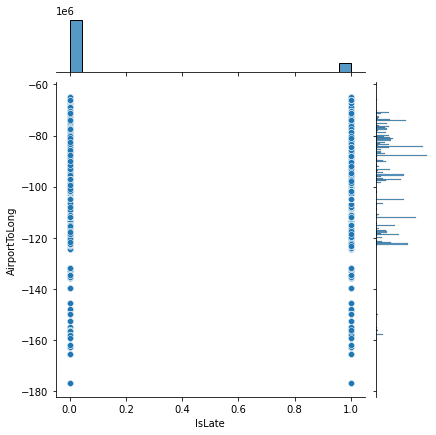

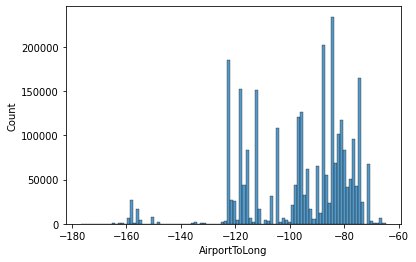

In [17]:
numerical_features = [
    "CRSElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "AirportFromLat",
    "AirportFromLong",
    "AirportToLat",
    "AirportToLong"
]

for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# Via data population, I can see that only the features like TaxiIn, Taxiout affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [18]:
def split_hour(date):
    return date[:2]

def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day

def add_prefix_to_time(time):
    return time.rjust(4, "0")

# df = df_backup.copy()
df["CRSDepTime"] = df["CRSDepTime"].apply(add_prefix_to_time)
df["CRSArrTime"] = df["CRSArrTime"].apply(add_prefix_to_time)
df["CRSDepTime_Hour"] = df["CRSDepTime"].apply(split_hour)
df["CRSArrTime_Hour"] = df["CRSArrTime"].apply(split_hour)
df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayofMonth"] = df["DayofMonth"].apply(add_prefix_to_date)
df["Diverted"] = df["Diverted"].map({"0": "Non-diverted", "1": "Diverted"})
df["PlaneIssueYear"] = df["PlaneIssueDate"].apply(lambda e: e.split("/")[-1])

# diverted is all NaN column, so I would drop this feature
df = df.drop(["CRSDepTime", "CRSArrTime", "PlaneIssueDate", "Diverted"], axis=1)

In [19]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().sort_index().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).sort_index().reset_index()
    
    column_values1 = visualize[visualize["IsLate"] == True][column].unique()
    column_values2 = visualize[visualize["IsLate"] == False][column].unique()
    
    column_values = list(set(column_values1) & set(column_values2))
    column_values.sort()
    
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]

    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

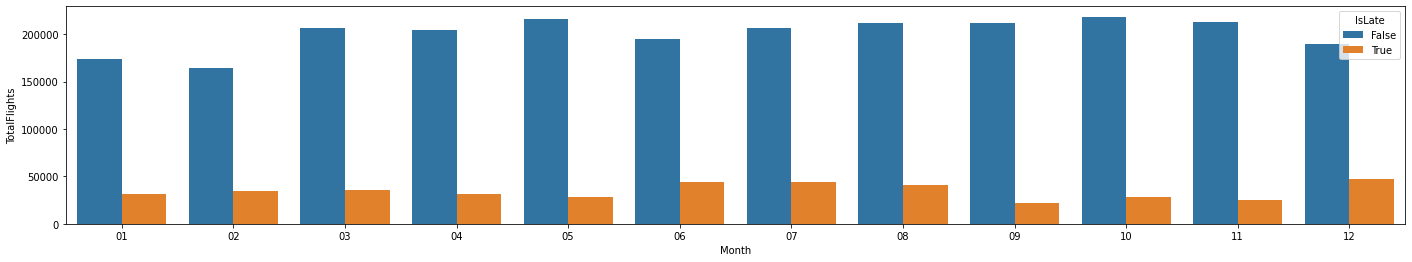

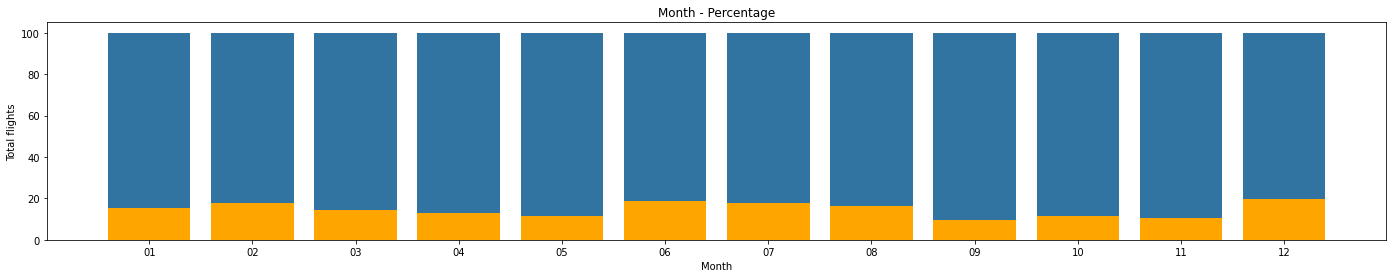

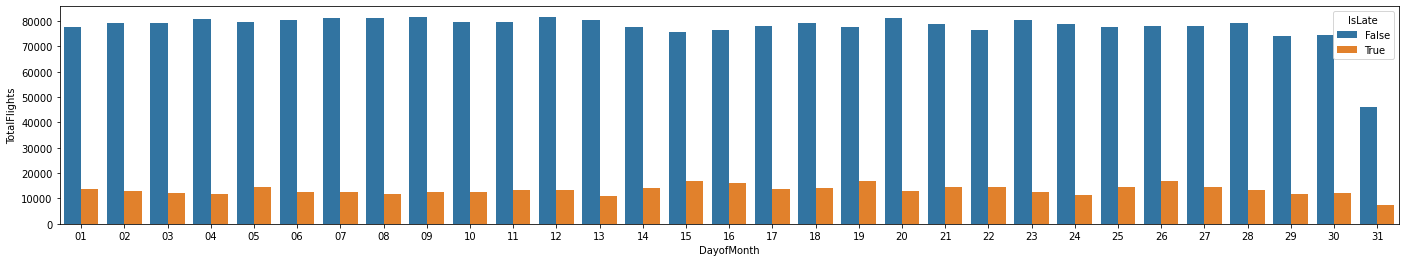

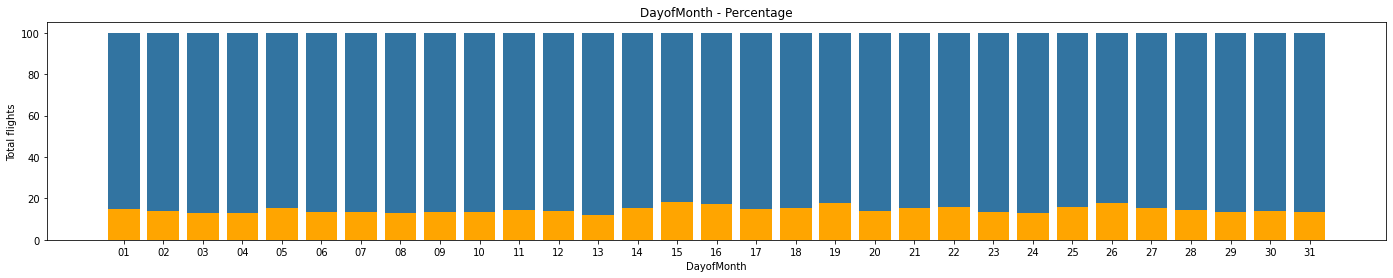

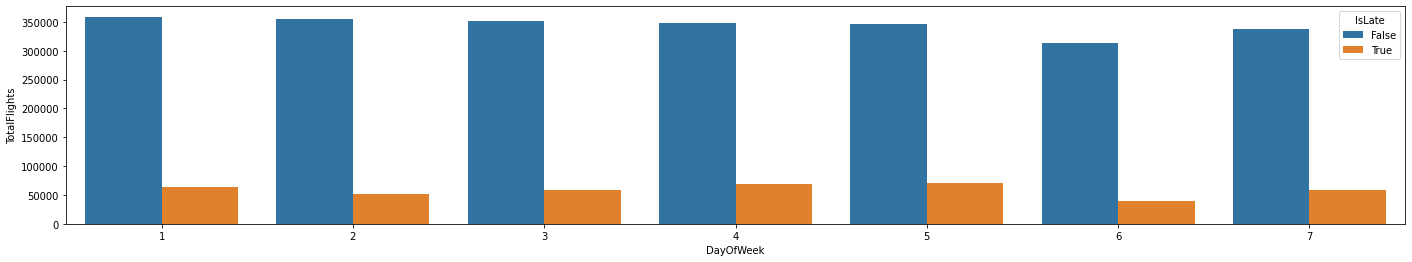

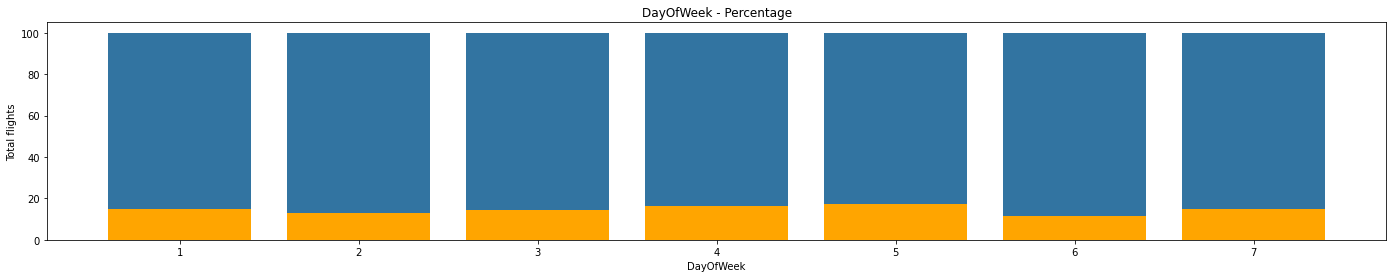

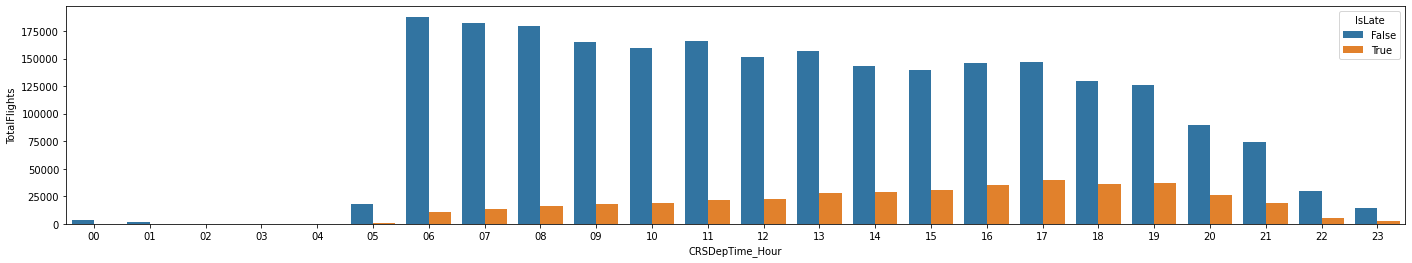

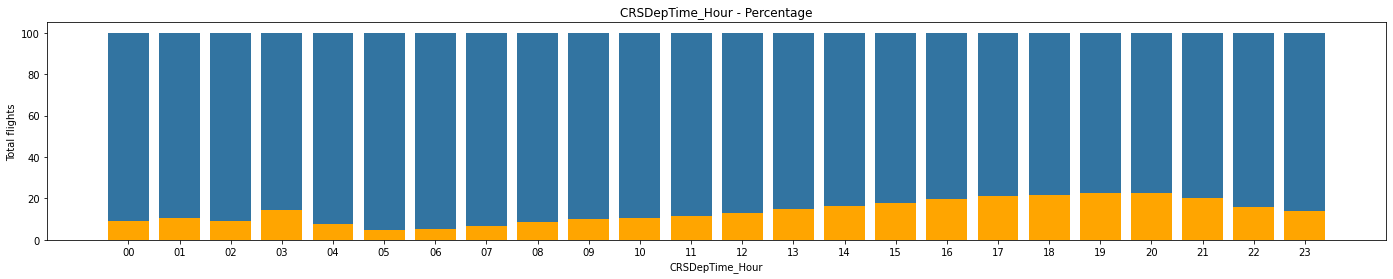

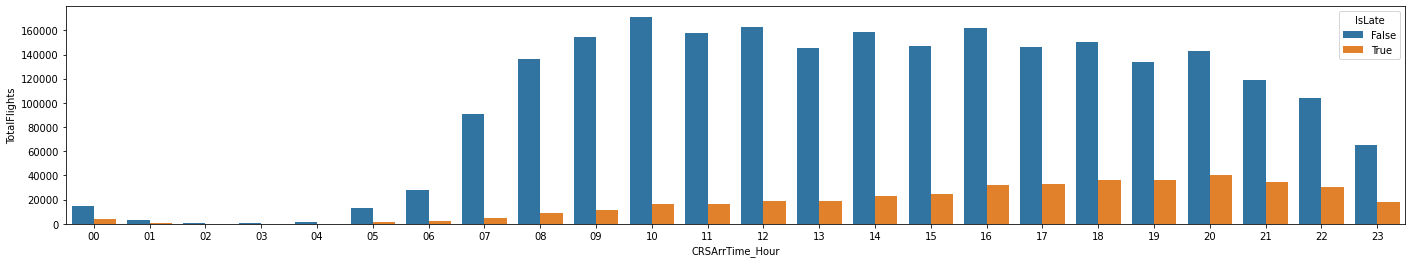

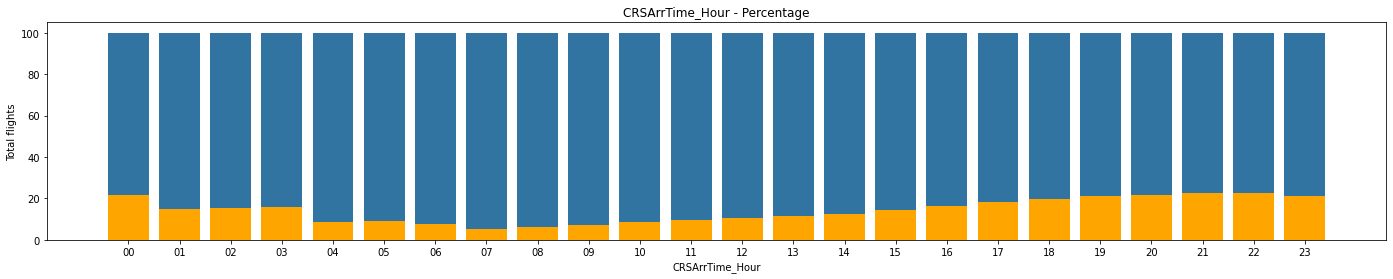

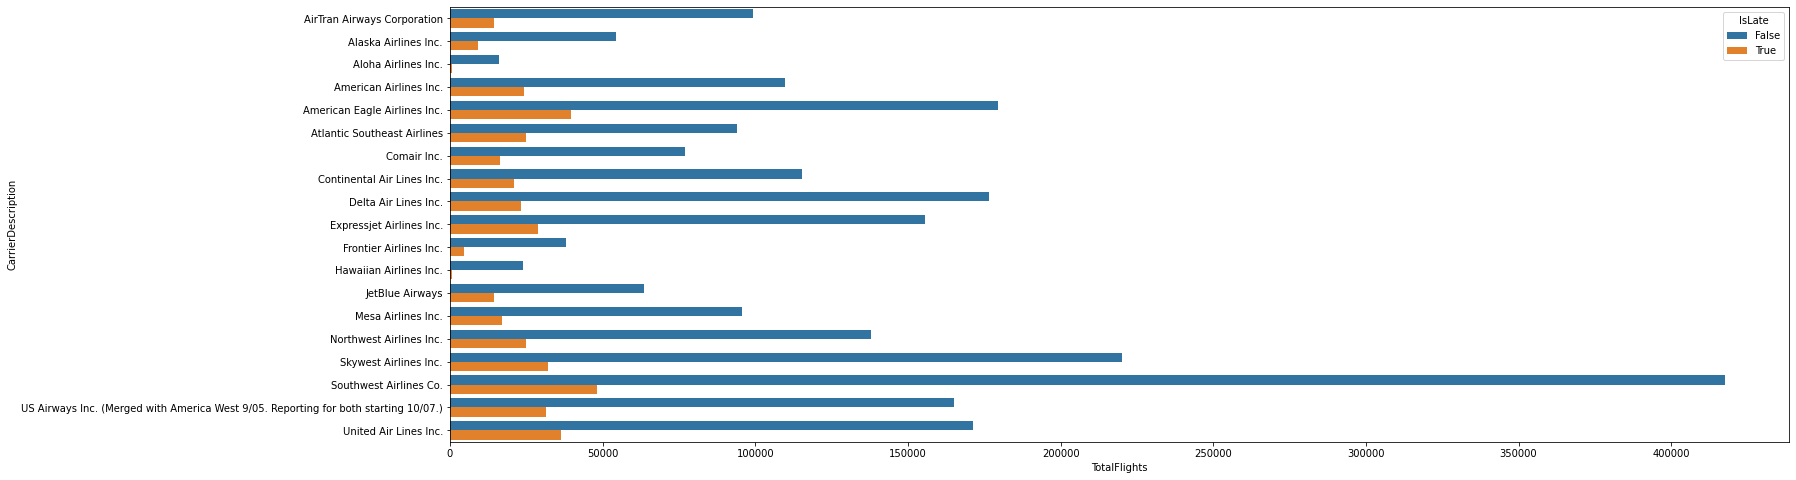

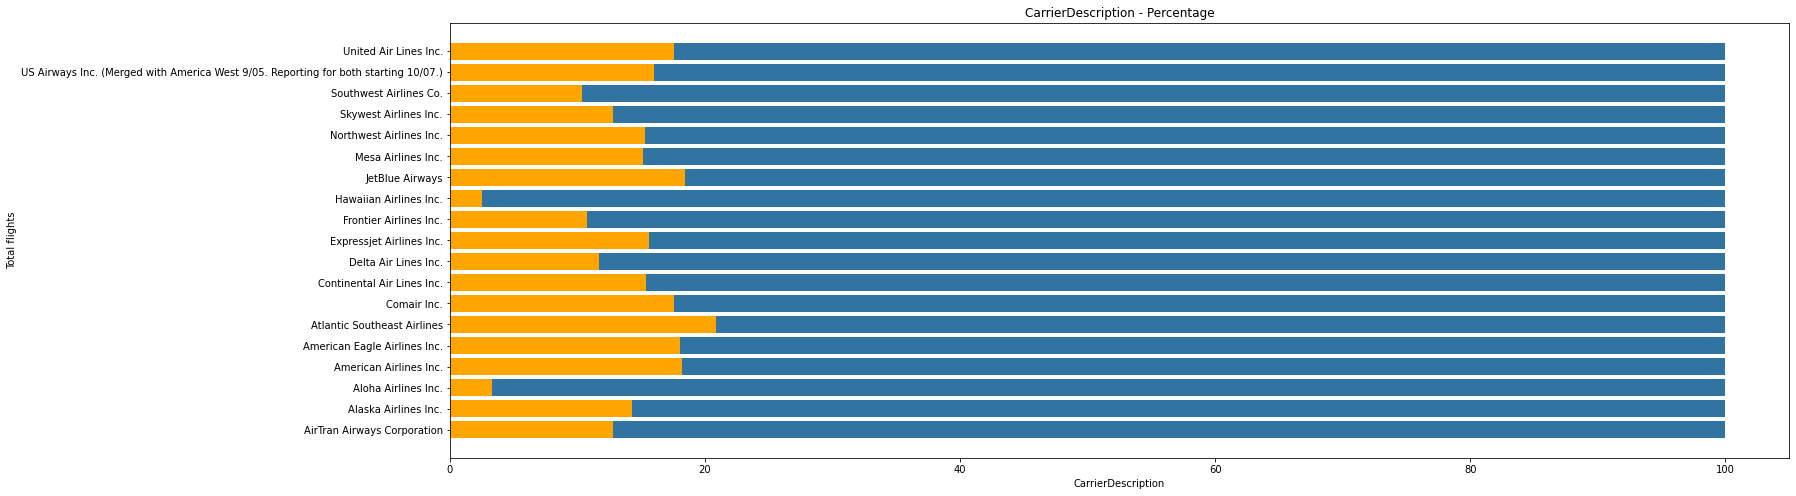

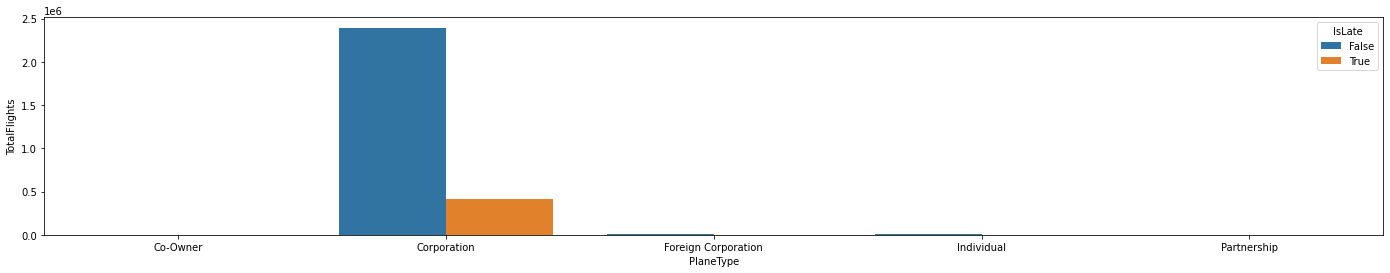

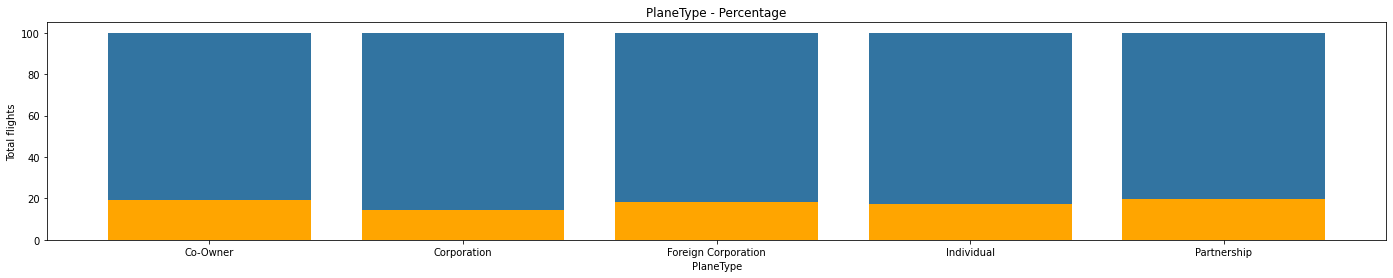

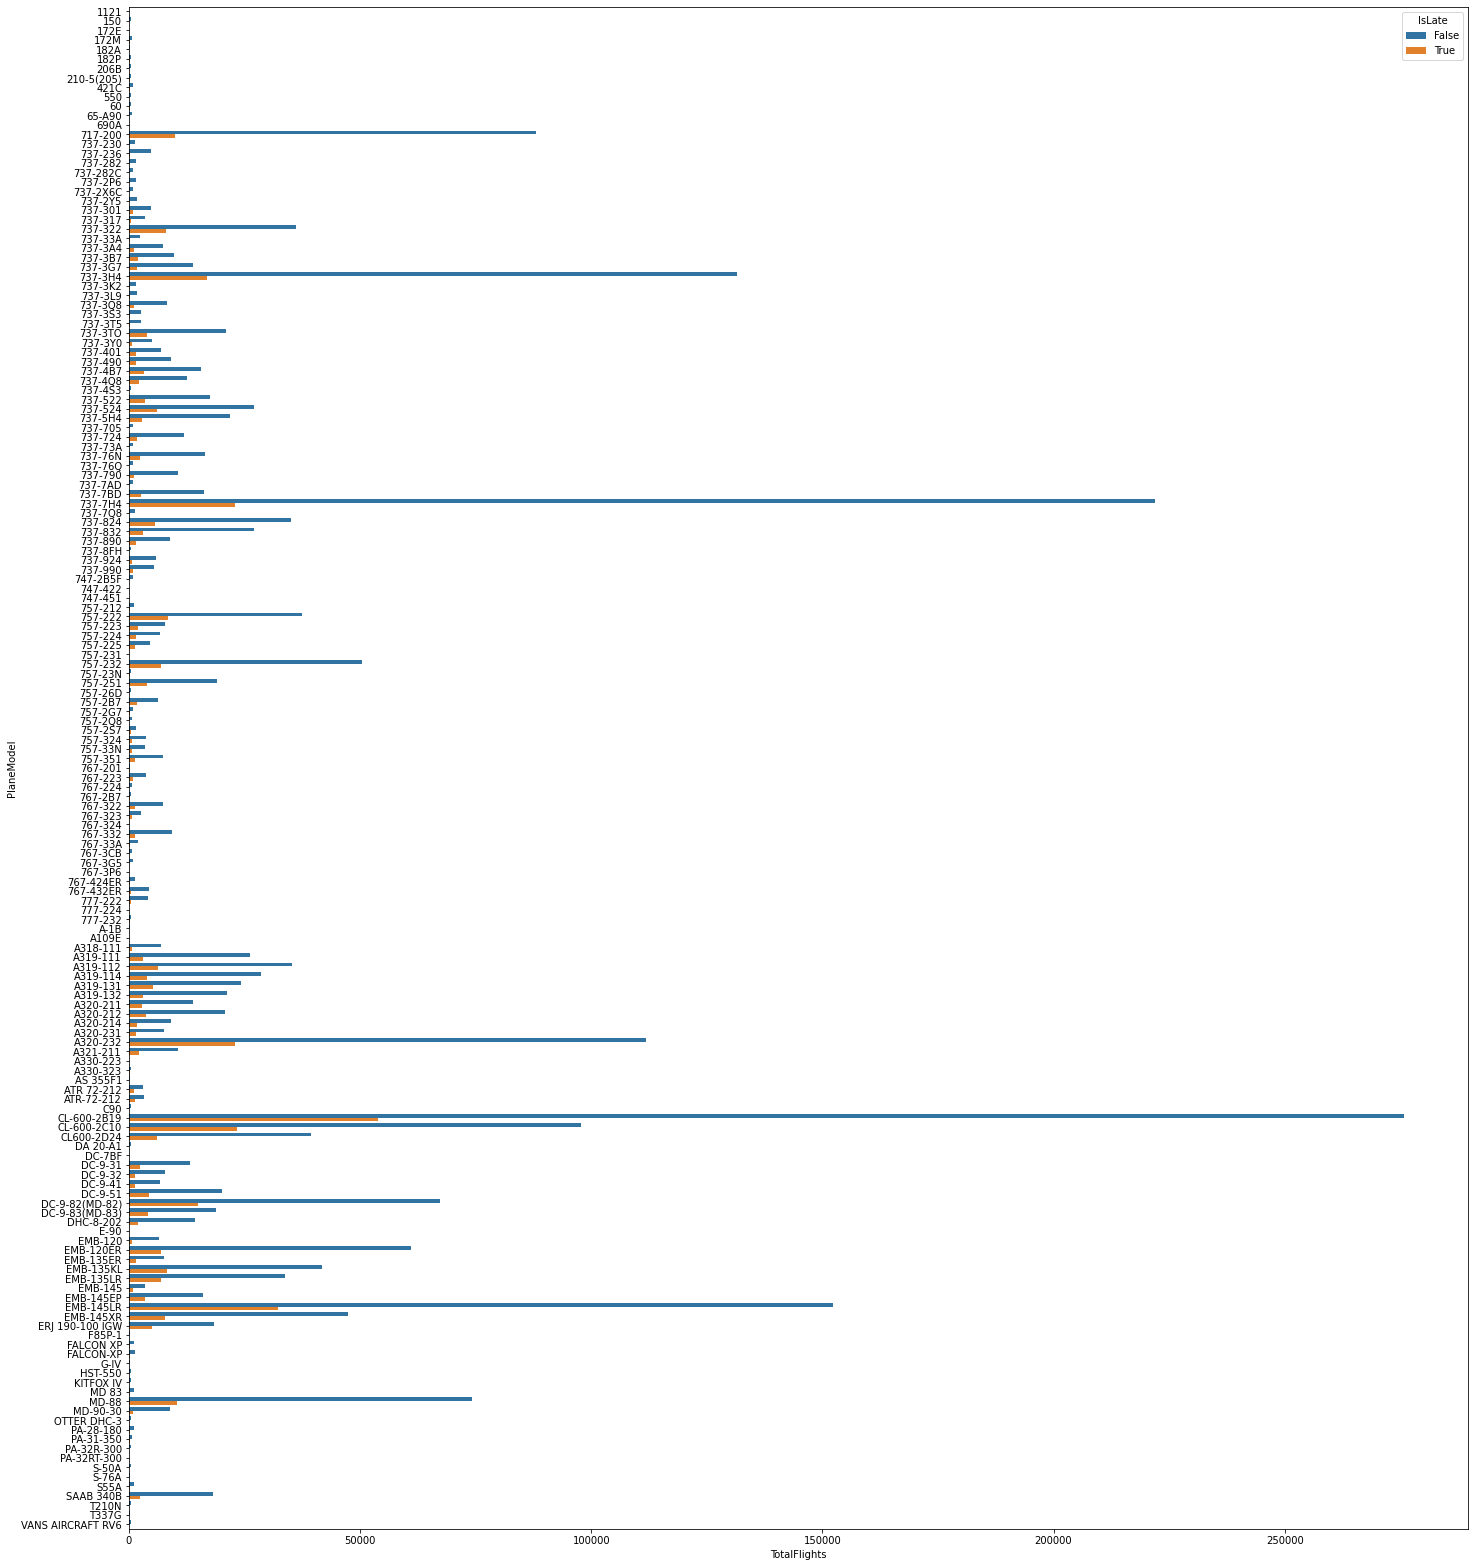

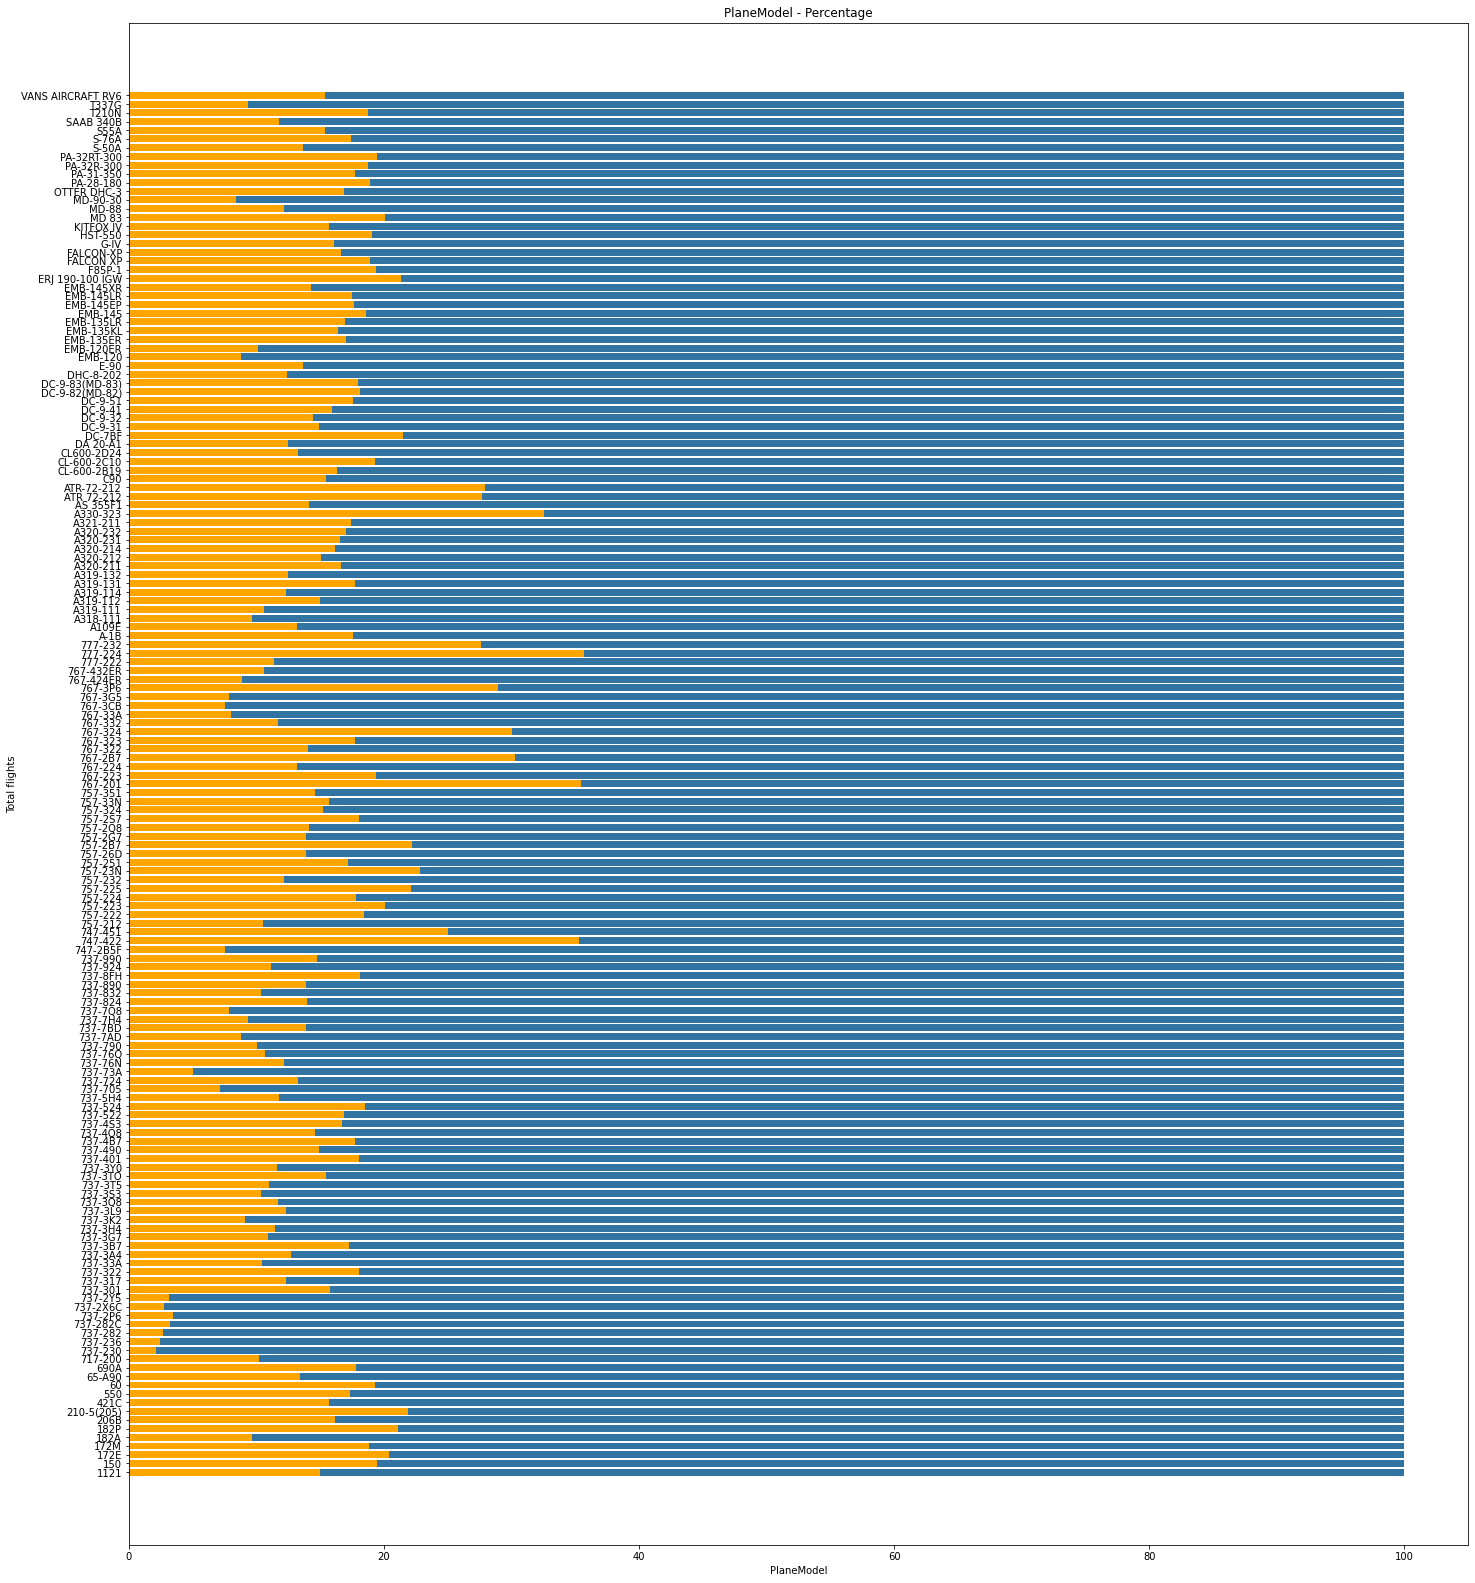

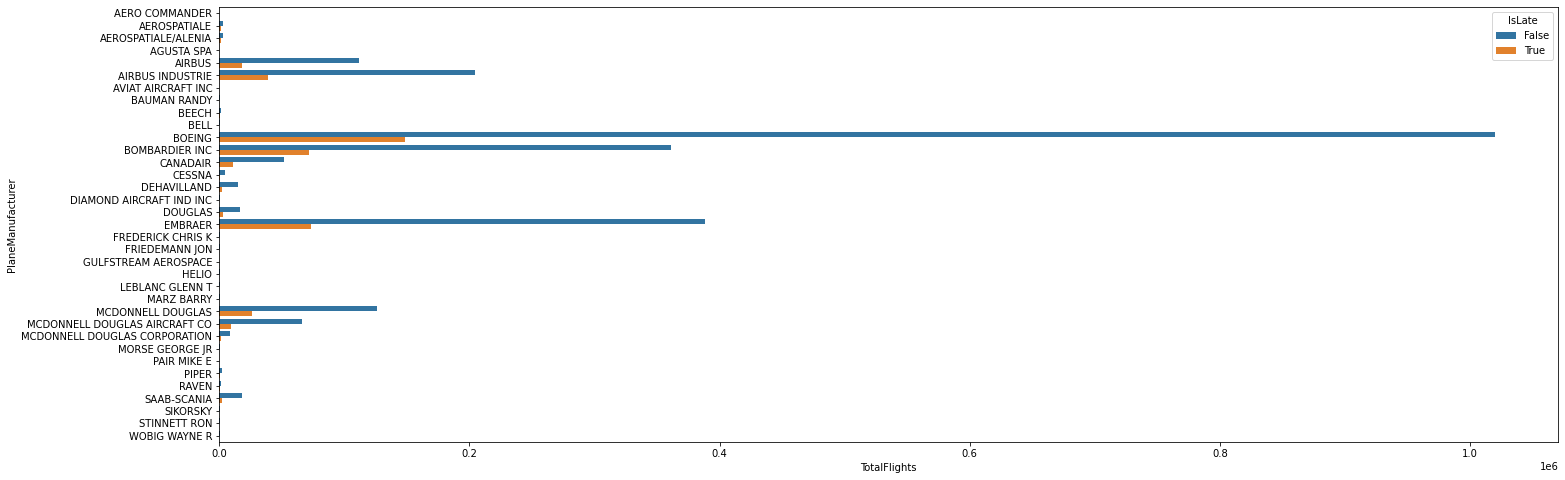

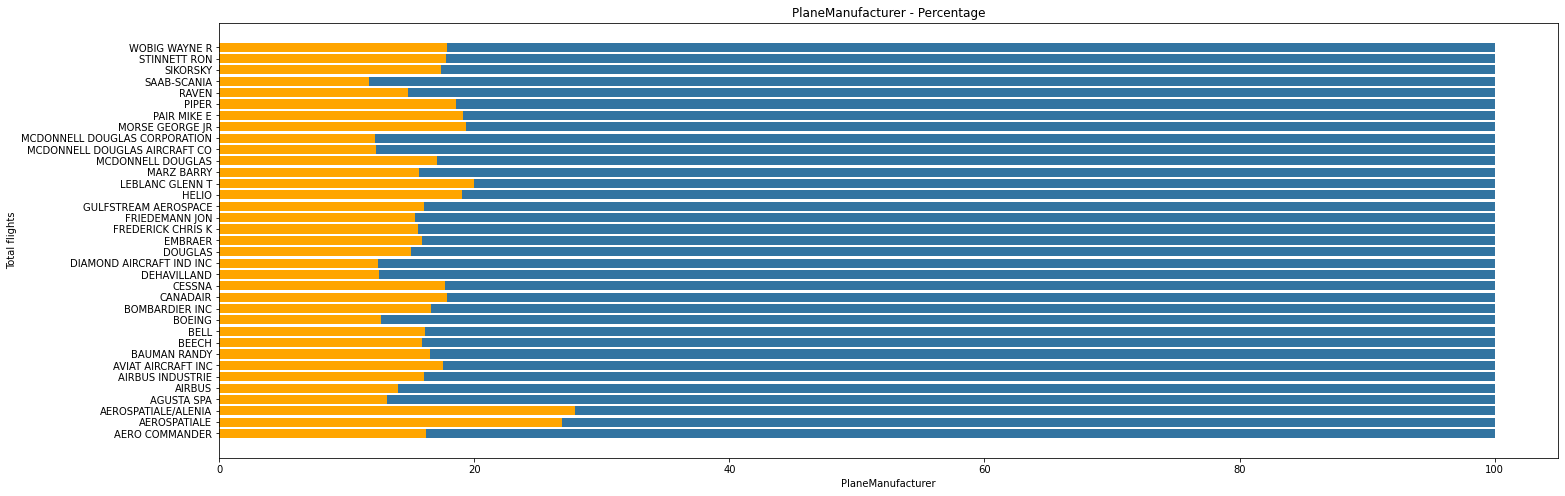

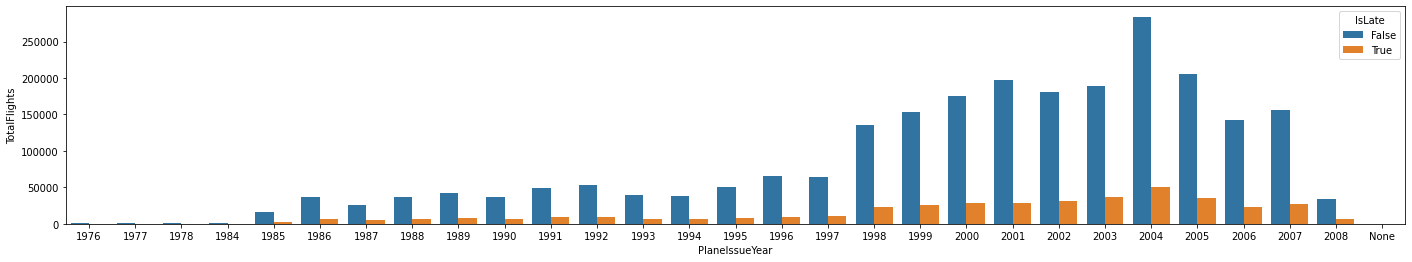

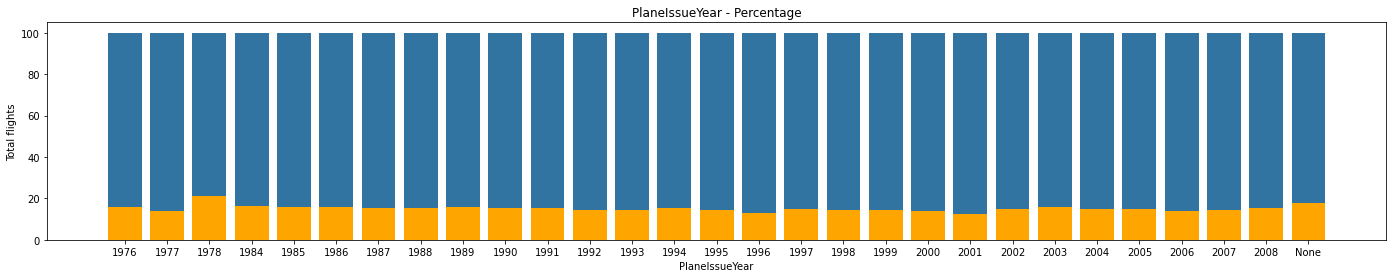

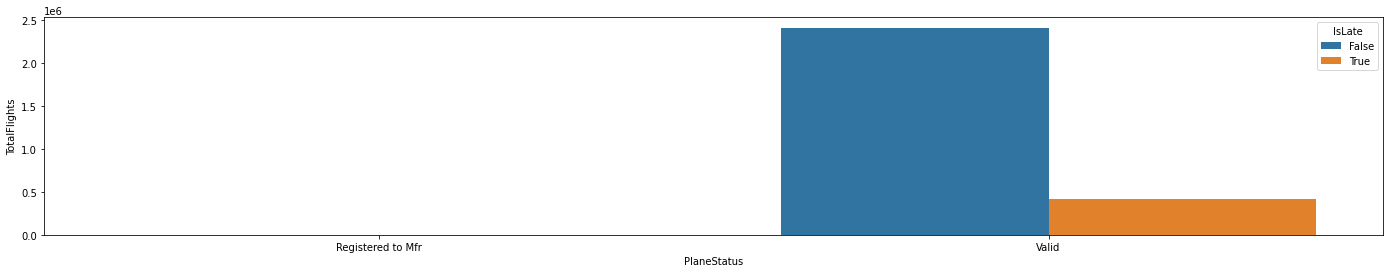

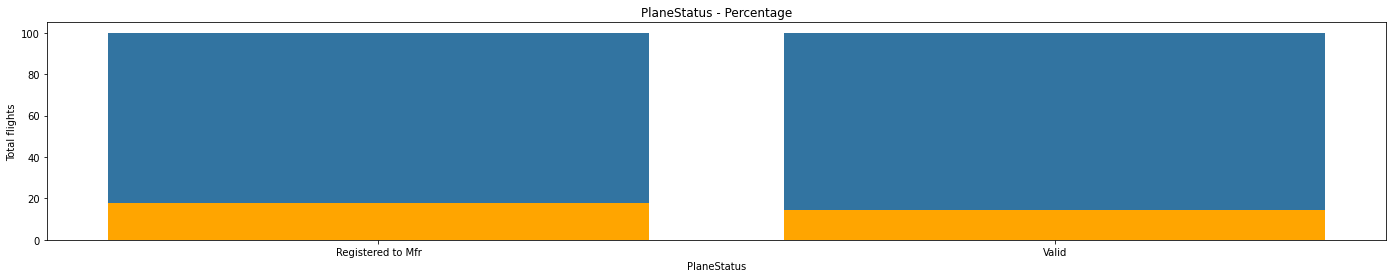

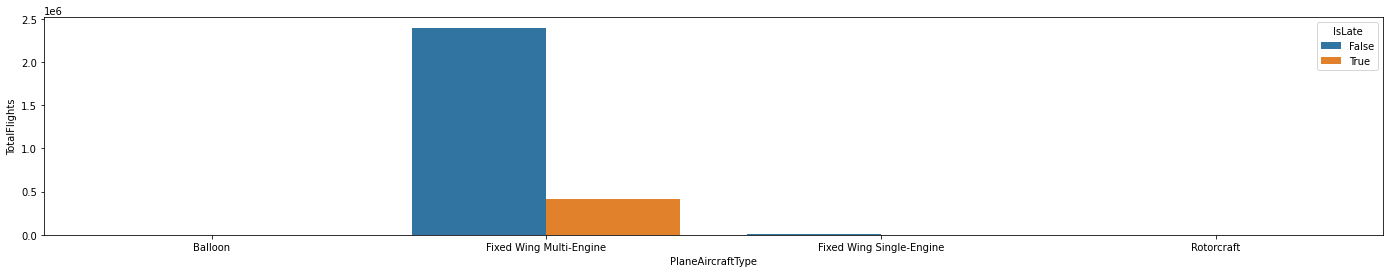

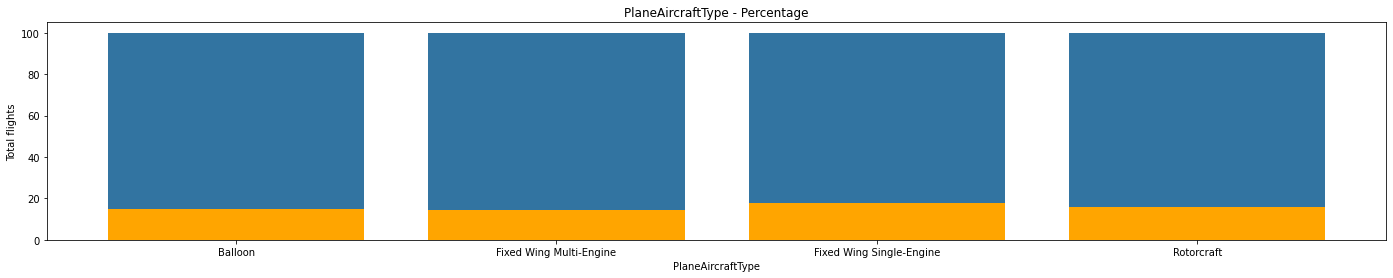

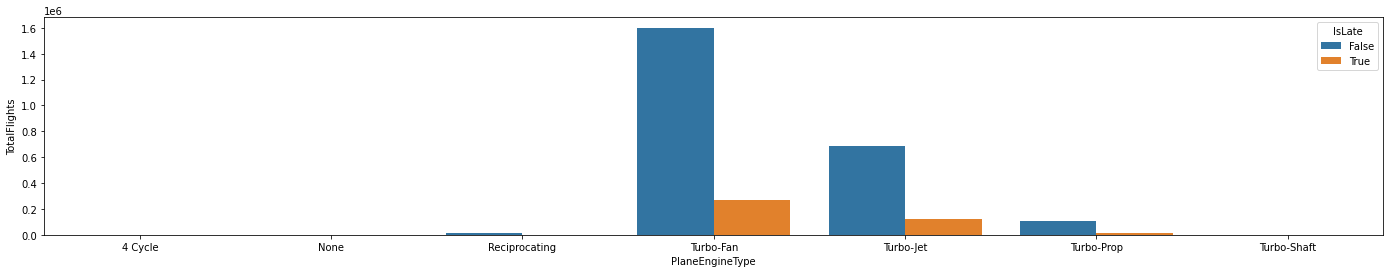

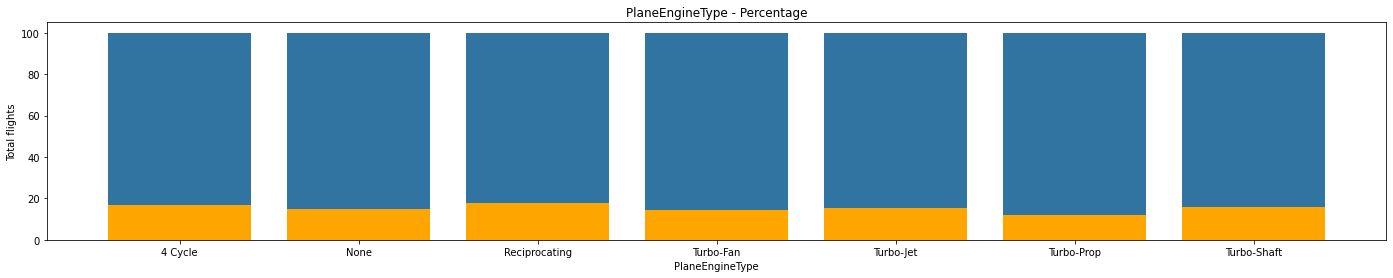

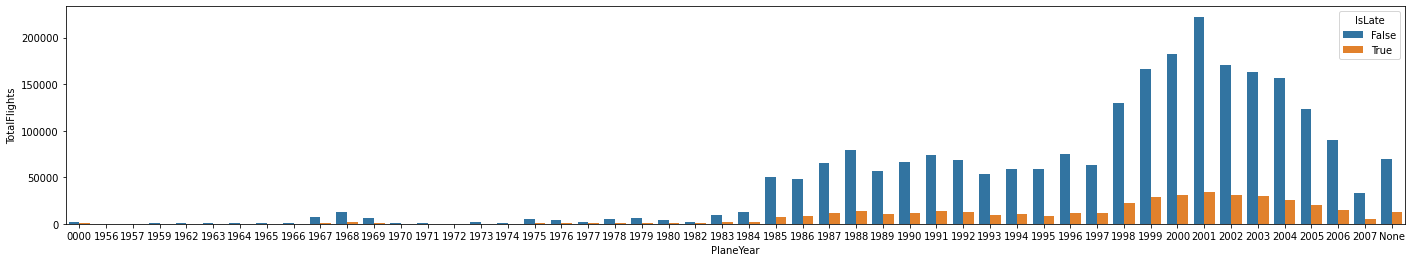

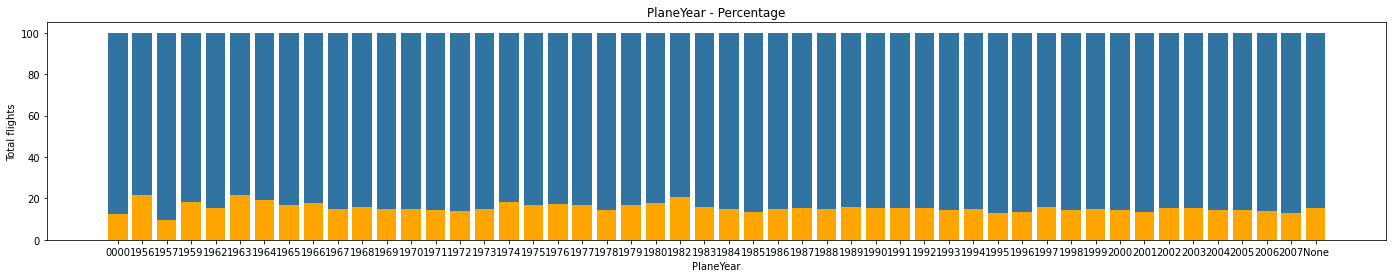

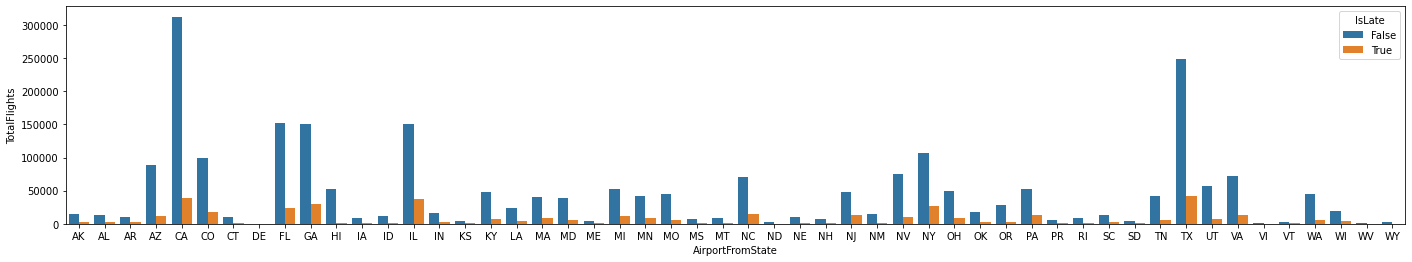

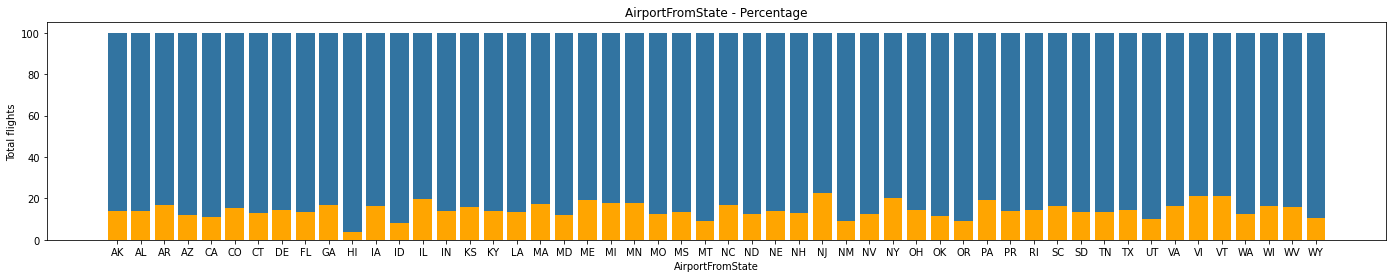

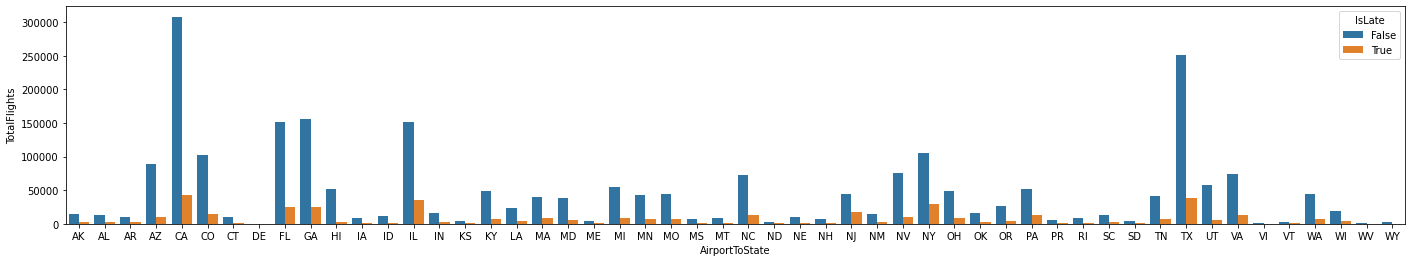

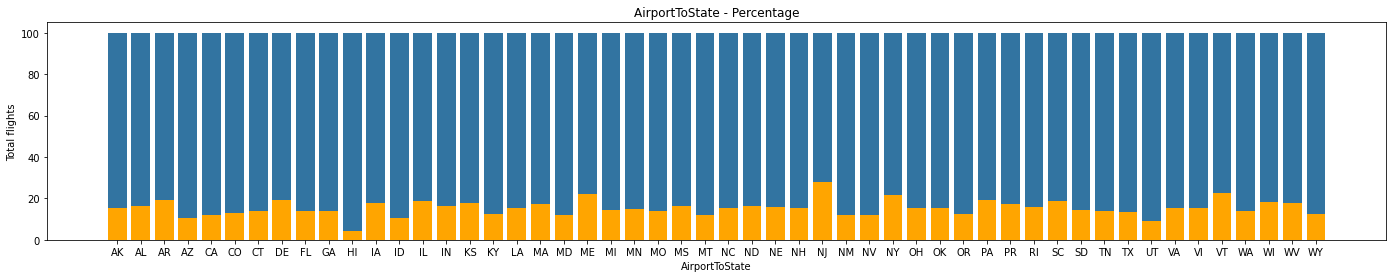

In [20]:
categorical_features = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
]
barh_columns = [
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription"
]

for column in categorical_features:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))

    # show IsLate percentage
    
    
    if column in barh_columns:
        height = 8 if column != "PlaneModel" else 28
        
        plt.figure(figsize=(24, height))
        sns.barplot(x="TotalFlights", hue="IsLate", y=column, data=visualize);
        plt.show()
        
        plt.figure(figsize=(24, height))
        plt.barh(column_values, is_late_percentage, color="orange")
        plt.barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    else:
        plt.figure(figsize=(24, 4))
        sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
        plt.show()
    
        plt.figure(figsize=(24, 4))
        plt.bar(column_values, is_late_percentage, color="orange")
        plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
        
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

From the visualized data, we can see that PlaneModel, DayofMonth, CRSDepTime_Hour, CRSArrTime_Hour, Month (4 months), CarrierDescription, PlaneManufacturer, AirportFromState, AirportToState have significant impact to the lateness of Flights.

In contrast, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, AircraftType don't show any promising influence to the lateness

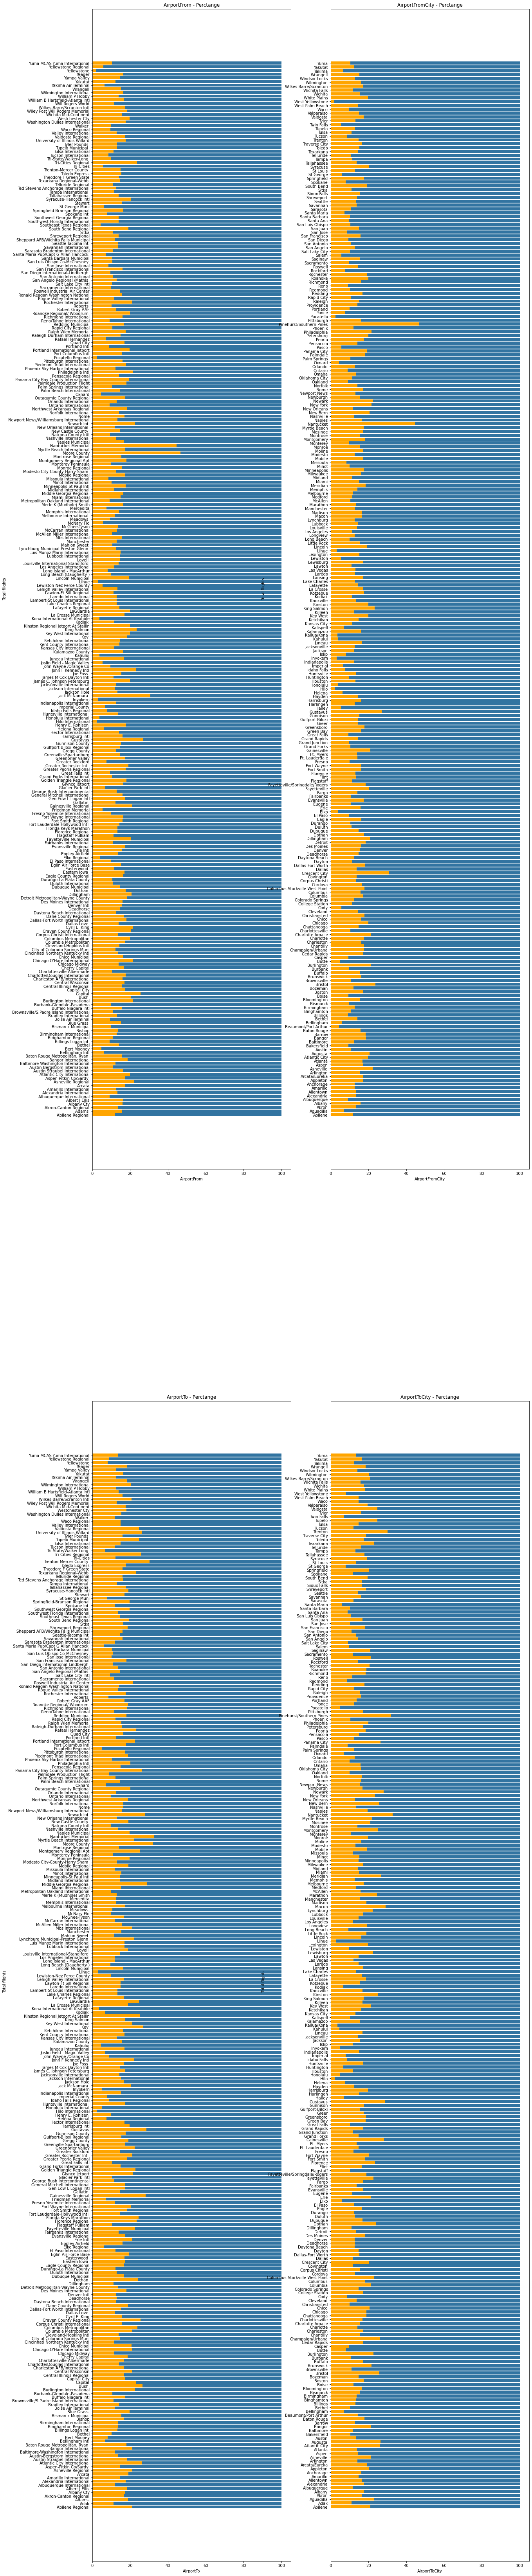

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 120))
columns = [["AirportFrom", "AirportFromCity"], ["AirportTo", "AirportToCity"]]

for index, (column1, column2) in enumerate(columns):
    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column1)

    ax[index][0].barh(column_values, is_late_percentage, color="orange")
    ax[index][0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][0].set_xlabel(column1)
    ax[index][0].set_ylabel("Total flights")
    ax[index][0].set_title(f"{column1} - Perctange")

    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column2)
    ax[index][1].barh(column_values, is_late_percentage, color="orange")
    ax[index][1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][1].set_xlabel(column2)
    ax[index][1].set_ylabel("Total flights")
    ax[index][1].set_title(f"{column2} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
According to the data, the late percentage is higher in the summer and winter season (by month) and in the night time. The DayOfWeek doesn't seem to have any impact on the lateness. Furthermore, DayOfMonth also doesn't show a clear effect on the lateness.

The most significant feature here is OpUniqueCarier, the late flights varies depending on this feature, because obviously there are some carriers most of the times depart in incorrected timing.

Besides, origin and dest also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land, ...

### Hypothesis Testing

The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and MORE USEFUL for classification. [link](https://stackoverflow.com/a/51697444)



In [22]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [23]:
dropping_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity"
]

for dropping_column in dropping_columns:
    table = df.groupby([dropping_column, "IsLate"]).size()
    table_values = table.values
    removed_indices = []
    
    for index, (key, values) in enumerate(table.items()):
        if (index == 0 and table.keys()[index + 1][0] != key[0]) or \
           (table.keys()[index - 1][0] != key[0] and table.keys()[index + 1][0] != key[0]) or \
           (index == len(table_values) - 1 and table.keys()[index - 1][0] != key[0]):
            removed_indices.append(index)

    for index in sorted(removed_indices, reverse=True):
        table_values = np.delete(table_values, index)

    table_len = len(table_values)
    table_values = table_values.reshape((table_len // 2, 2))
    stat, p, dof, expected = chi2_contingency(table_values)
    # show 31 days in every month to check when the demands increase
    # show the lateness also
    # stats.chi2.ppf(df.groupby(["DayofMonth", "IsLate"]).size().values.reshape((31, 2)))
    prob = 0.95
    critical = chi2.ppf(prob, dof)

    if abs(stat) >= critical:
        print(f"{dropping_column}: Dependent (reject H0)")
    else:
        print(f"{dropping_column}: Independent (fail to reject H0)")

Month: Dependent (reject H0)
DayofMonth: Dependent (reject H0)
DayOfWeek: Dependent (reject H0)
CRSDepTime_Hour: Dependent (reject H0)
CRSArrTime_Hour: Dependent (reject H0)
CarrierDescription: Dependent (reject H0)
PlaneType: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneManufacturer: Dependent (reject H0)
PlaneIssueYear: Dependent (reject H0)
PlaneStatus: Independent (fail to reject H0)
PlaneAircraftType: Dependent (reject H0)
PlaneEngineType: Dependent (reject H0)
PlaneYear: Dependent (reject H0)
AirportFromState: Dependent (reject H0)
AirportToState: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneManufacturer: Dependent (reject H0)
CarrierDescription: Dependent (reject H0)
AirportFrom: Dependent (reject H0)
AirportFromCity: Dependent (reject H0)
AirportTo: Dependent (reject H0)
AirportToCity: Dependent (reject H0)


Almost all of the features reject H0, which are clearly that the labels depended on them

### Filter noise & Feature engineering

In [24]:
from scipy import stats

# , we drop AirportFrom, AirportFromCity, AirportTo, AirportToCity, PlaneModel, and FlightNum
# similarly, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, PlaneEngineType, and PlaneAircraftType don't show any relation to the lateness
df = df.drop([
    # Independent columns
    "PlaneStatus",
    
    # Correlated column but having lower correlation coefficient
    "CRSElapsedTime",

    # These below features have so many unique values
    "FlightNum",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity",
    "PlaneModel",
    
    # PlaneYear and PlaneIssueYear also have plenty values whcih doesn't show a significant difference
    "PlaneYear",
    "PlaneIssueYear",
], axis=1)

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [25]:
df.head(5)

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,Distance,TaxiIn,TaxiOut,CarrierDescription,PlaneType,PlaneManufacturer,...,PlaneEngineType,AirportFromState,AirportFromLat,AirportFromLong,AirportToState,AirportToLat,AirportToLong,IsLate,CRSDepTime_Hour,CRSArrTime_Hour
3453826,11,08,4,84.0,264,6,24,Comair Inc.,Corporation,CANADAIR,...,Turbo-Jet,NY,43.118866,-77.672384,NY,40.639751,-73.778926,False,06,07
5228334,03,29,4,67.0,270,4,17,AirTran Airways Corporation,Corporation,BOEING,...,Turbo-Fan,GA,33.640444,-84.426944,FL,30.494056,-81.687861,False,08,09
5670575,05,30,3,146.0,867,5,21,United Air Lines Inc.,Corporation,BOEING,...,Turbo-Fan,IL,41.979595,-87.904464,MA,42.364348,-71.005179,False,06,10
6671867,06,19,2,50.0,122,3,13,Skywest Airlines Inc.,Corporation,BOMBARDIER INC,...,Turbo-Fan,IL,41.979595,-87.904464,MI,42.234875,-85.552058,False,13,15
422590,06,20,3,142.0,834,9,11,Alaska Airlines Inc.,Corporation,BOEING,...,Turbo-Fan,OR,45.588722,-122.597500,CA,33.942536,-118.408074,False,09,11


In [27]:
dummy_columns = [
    "DayofMonth",
    "DayOfWeek",
    "PlaneType",
    "PlaneAircraftType",
    "PlaneEngineType",
    "CarrierDescription",
    "PlaneManufacturer",
    "AirportFromState",
    "AirportToState",
]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True, dtype=bool))
    
df = df.drop(dummy_columns, axis=1)

In [28]:
# feature engineering
# I see the abnormal from these hours and months, so I decided to create the new features for them
# calculate IG of CRSElapsedTime and Distance
df["IsArrTimeNoonOrEvening"] = df["CRSArrTime_Hour"].isin([str(i) for i in range(13, 24)])
df["IsUnusualCRSDepHour"] = df["CRSDepTime_Hour"].isin(["16", "17", "18", "19", "20", "21", "22", "23", "00", "01", "02", "03"])
df["IsSummerOrWinter"] = df["Month"].isin(["12", "01", "02", "06", "07", "08"])

df = df.drop(["CRSArrTime_Hour", "CRSDepTime_Hour", "Month"], axis=1)

In [29]:
df.head(5)

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong,IsLate,DayofMonth_02,...,AirportToState_UT,AirportToState_VA,AirportToState_VT,AirportToState_WA,AirportToState_WI,AirportToState_WV,AirportToState_WY,IsArrTimeNoonOrEvening,IsUnusualCRSDepHour,IsSummerOrWinter
3453826,84.0,264,6,24,43.118866,-77.672384,40.639751,-73.778926,False,False,...,False,False,False,False,False,False,False,False,False,False
5228334,67.0,270,4,17,33.640444,-84.426944,30.494056,-81.687861,False,False,...,False,False,False,False,False,False,False,False,False,False
5670575,146.0,867,5,21,41.979595,-87.904464,42.364348,-71.005179,False,False,...,False,False,False,False,False,False,False,False,False,False
6671867,50.0,122,3,13,41.979595,-87.904464,42.234875,-85.552058,False,False,...,False,False,False,False,False,False,False,True,False,True
422590,142.0,834,9,11,45.588722,-122.597500,33.942536,-118.408074,False,False,...,False,False,False,False,False,False,False,False,False,True


In [30]:
from sklearn.model_selection import train_test_split

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = numerical_features

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

In [31]:
del df, X, y

### Train models

#### ROC curve
__Definition:__ a graph showing the performance of a classification model at all classification thresholds. Plot two params:
- True Positive Rate: $ TPR = \frac{TP}{TP + FN} $ (denominator is positivity **True Positive** -> **Positive**, mẫu số là tổng số dương tính)
- False Positive Rate: $ FPR = \frac{FP}{FP + TN} $ (denominator is negativity, **False Positive** -> **Negative**, mẫu số là tổng số âm tính)

__Reference:__ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

This graph doesn't show any promising result when classifying late or not late flights.

In [32]:
def show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"data 1, auc={auc}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    
    P = metrics.precision_score(y_test, y_pred)
    R = metrics.recall_score(y_test, y_pred)
    F = 2 * ((P * R) / (P + R))
    print("Precision:", P)
    print("Recall:", R)
    print("F1 score:", F)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn import metrics
import time

In [34]:
training_columns = X_train.columns

In [35]:
def train_n_visualize_model(modelClass, X_train, y_train, X_test, y_test):
    start = time.time()

    model = modelClass()
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train_pca.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

Due to the extremely imbalanced dataset, we can't use accuracy as a suitable score.

Rather, we use recall because it's more appropriate in this situtation, because it actually measures rate of the predicted late flights among the ground-truth late flights.

#### Logistic Regression

Total time to train model: 64.45430874824524
Test score: 0.8702809100489662
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      0.99      0.93    554414
     class 1       0.59      0.05      0.09     84189

    accuracy                           0.87    638603
   macro avg       0.73      0.52      0.51    638603
weighted avg       0.84      0.87      0.82    638603



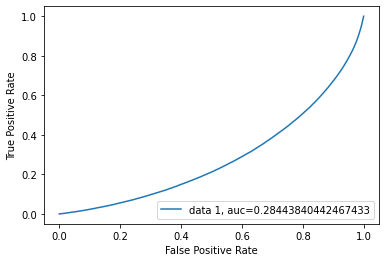

Precision: 0.5924657534246576
Recall: 0.0513725070971267
F1 score: 0.09454688541791909


,Column,Amount
3,TaxiOut,3.041548
1,Distance,1.581208
4,AirportFromLat,0.943858
183,AirportToState_NJ,0.819554
2,TaxiIn,0.725677
...,...,...
118,AirportFromState_ID,-0.974045
142,AirportFromState_OR,-1.012184
152,AirportFromState_WA,-1.094695
149,AirportFromState_UT,-1.094867


In [36]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train, y_train, X_test, y_test)
importances

As we can see, LogisticRegression performs not so well in this dataset. I guess because the dataset doesn't have linear trending features to feed to the model.

In [37]:
del model1, _

#### Decision Tree

Total time to train model: 197.1325511932373
Test score: 0.8052608584676239
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.88      0.89    554414
     class 1       0.27      0.29      0.28     84189

    accuracy                           0.81    638603
   macro avg       0.58      0.59      0.58    638603
weighted avg       0.81      0.81      0.81    638603



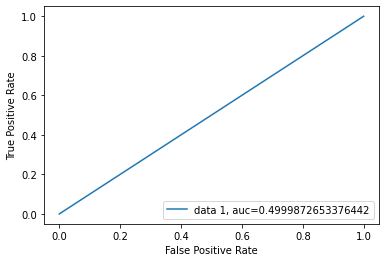

Precision: 0.27438051805090646
Recall: 0.2901447932627778
F1 score: 0.2820425482781514


In [38]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test)
importances

The recall is higher, we could predict 24% of late flight correctly

In [39]:
del model2, _

#### Naive Bayes

Total time to train model: 37.69725298881531
Test score: 0.5913877636027391
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.90      0.59      0.72    554414
     class 1       0.18      0.58      0.27     84189

    accuracy                           0.59    638603
   macro avg       0.54      0.59      0.49    638603
weighted avg       0.81      0.59      0.66    638603



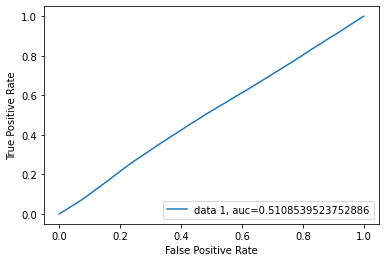

Precision: 0.17756105747830972
Recall: 0.578068393733148
F1 score: 0.2716739934407927


In [40]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train, y_train, X_test, y_test)
importances

In [41]:
del model3, _

#### Support Vector Machine

In [41]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 179.01337814331055
Test score: 0.867631493242143
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.98      0.93    553793
     class 1       0.51      0.11      0.17     84871

    accuracy                           0.87    638664
   macro avg       0.69      0.55      0.55    638664
weighted avg       0.83      0.87      0.83    638664



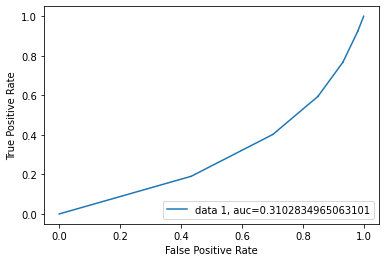

Precision: 0.5094350346709106
Recall: 0.10560733348257945
F1 score: 0.1749475430634851


In [44]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train, y_train, X_test, y_test)
importances

In [45]:
del model5, _

## PCA

In [42]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

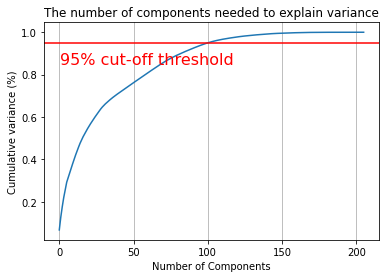

In [43]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel("Number of Components")
plt.ylabel("Cumulative variance (%)")
plt.title("The number of components needed to explain variance")

plt.axhline(y=0.95, color='r', linestyle="-")
plt.text(0.5, 0.85, "95% cut-off threshold", color="red", fontsize=16)
ax.grid(axis="x")
plt.show()

In [44]:
pca = PCA(n_components=100).fit(X_train)

In [45]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [158]:
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     print(var, sys.getsizeof(obj))

#### Logistic Regression

Total time to train model: 39.56674289703369
Test score: 0.8697124817766281
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    554414
     class 1       0.59      0.04      0.07     84189

    accuracy                           0.87    638603
   macro avg       0.73      0.52      0.50    638603
weighted avg       0.83      0.87      0.82    638603



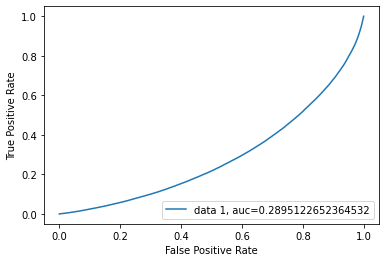

Precision: 0.589159891598916
Recall: 0.03873427644941738
F1 score: 0.07268958138290758


,Amount
99,1.303396
98,1.100650
2,0.893804
81,0.546239
86,0.524365
...,...
89,-0.542547
76,-0.601176
94,-0.777913
95,-1.102649


In [46]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_pca, y_train, X_test_pca, y_test)
importances

In [47]:
del model1, _

#### Decision Tree

Total time to train model: 1225.9022688865662
Test score: 0.7973222226397605
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.88      0.88    553793
     class 1       0.26      0.29      0.27     84871

    accuracy                           0.80    638664
   macro avg       0.57      0.58      0.58    638664
weighted avg       0.81      0.80      0.80    638664



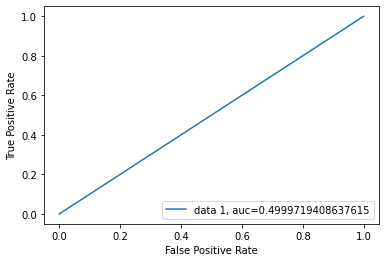

Precision: 0.26075147611379496
Recall: 0.2861872724487752
F1 score: 0.27287791889720875


In [52]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [53]:
del model2, _

#### Naive Bayes

Total time to train model: 4.137301921844482
Test score: 0.8008637604270572
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.88      0.89    554414
     class 1       0.25      0.26      0.25     84189

    accuracy                           0.80    638603
   macro avg       0.57      0.57      0.57    638603
weighted avg       0.80      0.80      0.80    638603



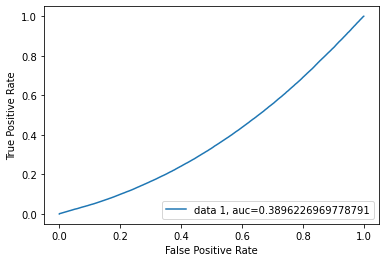

Precision: 0.25068448651909603
Recall: 0.2566606088681419
F1 score: 0.2536373507057546


In [48]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_pca, y_train, X_test_pca, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [55]:
del model3, _

#### Support Vector Machine

In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 726.1589410305023
Test score: 0.8677942320972498
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.98      0.93    554414
     class 1       0.49      0.10      0.17     84189

    accuracy                           0.87    638603
   macro avg       0.69      0.54      0.55    638603
weighted avg       0.83      0.87      0.83    638603



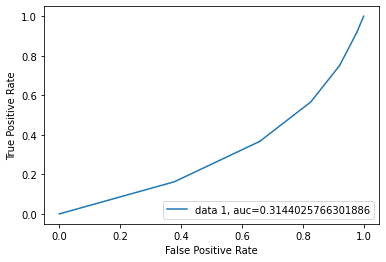

Precision: 0.4933198607836533
Recall: 0.10438418320683225
F1 score: 0.17230865758850228


In [65]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

In [66]:
del model5, _

## SelectKBest

In [50]:
from sklearn.feature_selection import SelectKBest

selectKBest = SelectKBest(k=20)
selectKBest.fit(X_train, y_train)
X_train_kbest = selectKBest.transform(X_train)
X_test_kbest = selectKBest.transform(X_test)

print("New shape after transforming: ", X_train_kbest.shape)

New shape after transforming:  (1915809, 20)


#### Logistic Regression

Total time to train model: 8.12437105178833
Test score: 0.8695339671125879
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    554414
     class 1       0.58      0.04      0.07     84189

    accuracy                           0.87    638603
   macro avg       0.72      0.52      0.50    638603
weighted avg       0.83      0.87      0.82    638603



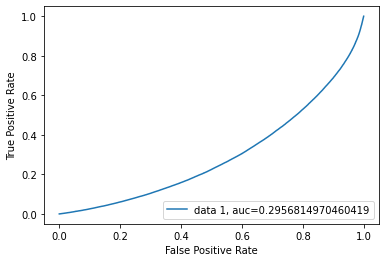

Precision: 0.5764046910554875
Recall: 0.0391143736117545
F1 score: 0.07325754710684967


,Amount
1,2.768253
0,0.687964
17,0.683414
15,0.614146
7,0.500075
18,0.498600
19,0.446005
14,0.285183
10,0.246978
16,0.237924


In [52]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [53]:
del model1, _

#### Decision Tree

Total time to train model: 26.032225847244263
Test score: 0.8020632536959582
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89    554414
     class 1       0.24      0.23      0.23     84189

    accuracy                           0.80    638603
   macro avg       0.56      0.56      0.56    638603
weighted avg       0.80      0.80      0.80    638603



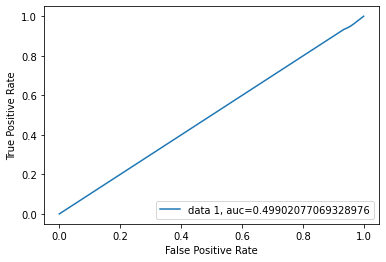

Precision: 0.23659711476064493
Recall: 0.22519569064842201
F1 score: 0.2307556550897329


In [61]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [62]:
del model2, _

#### Naive Bayes

Total time to train model: 2.101217031478882
Test score: 0.7925221146784466
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.87      0.88    554414
     class 1       0.25      0.30      0.27     84189

    accuracy                           0.79    638603
   macro avg       0.57      0.58      0.58    638603
weighted avg       0.81      0.79      0.80    638603



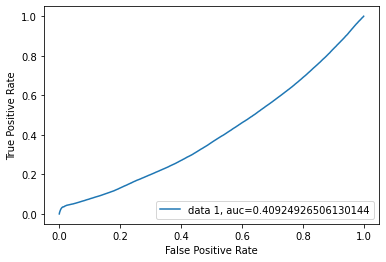

Precision: 0.254923646694739
Recall: 0.29842378457993324
F1 score: 0.2749638839031651


In [54]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_kbest, y_train, X_test_kbest, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [55]:
del model3, _

#### Support Vector Machine

In [65]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 81.93305611610413
Test score: 0.8428616840196491
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    554414
     class 1       0.30      0.14      0.19     84189

    accuracy                           0.84    638603
   macro avg       0.59      0.54      0.55    638603
weighted avg       0.80      0.84      0.82    638603



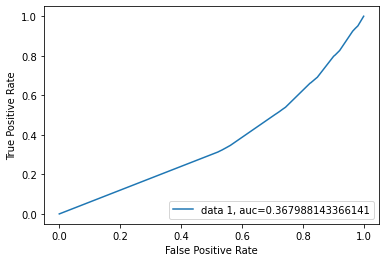

Precision: 0.29655554436499143
Recall: 0.13989951181270713
F1 score: 0.19011339332553168


In [63]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [64]:
del model5, _

## RFE

In [56]:
from sklearn.feature_selection import RFE

In [57]:
def train_n_visualize_model_with_rfe(estimator, X_train, y_train, X_test, y_test, n_features_to_select=10, step=1):
    start = time.time()

    model = RFE(estimator, n_features_to_select=10, step=1)
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train_pca.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

In [ ]:
model2, _, importances = train_n_visualize_model_with_rfe(GaussianNB(), X_train_kbest, y_train, X_test_kbest, y_test)
importances

### Decision Tree

Total time to train model: 240.00180983543396
Test score: 0.8132157224441476
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.91      0.89    554414
     class 1       0.24      0.20      0.22     84189

    accuracy                           0.81    638603
   macro avg       0.56      0.55      0.56    638603
weighted avg       0.80      0.81      0.80    638603



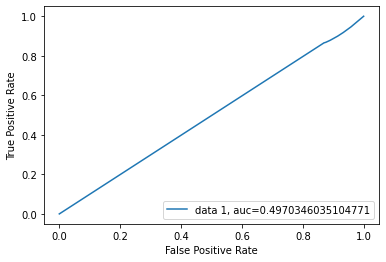

Precision: 0.24230407707672424
Recall: 0.19596384325743268
F1 score: 0.2166840691634324


In [59]:
model1, _, importances = train_n_visualize_model_with_rfe(DecisionTreeClassifier(), X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [60]:
del model1, _

# Summary
- Dimensionality reduction methods:
    - NaiveBayes and RandomForest perform ineffectively when having many features. When not applying RFE or PCA, the performance is low compared to when applying them.
    - They don't positively impact other algorithms like DecisionTree and LogisticRegression. In several case they could reduce the performance.
- I can't train SVM because it takes so long to finish (even longer than RandomForest)
- I can't show the the Residual and Homoscedasticity plots because this is a binary classification problem.
- This problem doesn't have any particular features strongly affect the label. It's quite understandable because if we can build high confidence model, it could innovate the flight lateness problem.
- Recall is the most effective factor here to evaluate the model because it predicts a recall rate per each label. It is important to correctly increase the rate of predicted late flights and actual late flights (recall).